### Here I'm going to go off book and test the basictree based model discussed in the book, on synthetic data

First I generate some synthetic data according to the distribution
$$Y = X_1X_2 + X_3$$
where all $X$ are normal and uncorrelated. I also add a non causal parameter $X_4$ which has pearson correlation $\frac{1}{2}$ to $X_1$.

This is far from the ideal tree model case, since trees will flourish in cases where binary splits carry heavy weight, whereas in a normal model like this any given split point has fuzzy edges so to speak.

First let's generate the $X$:s and $Y$, as well as making sure that our $X$ are correctly distributed.

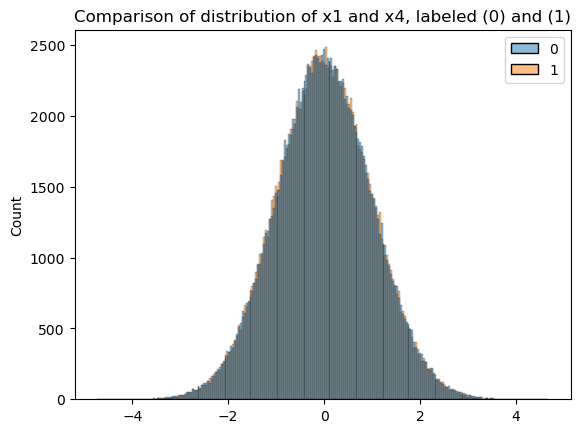

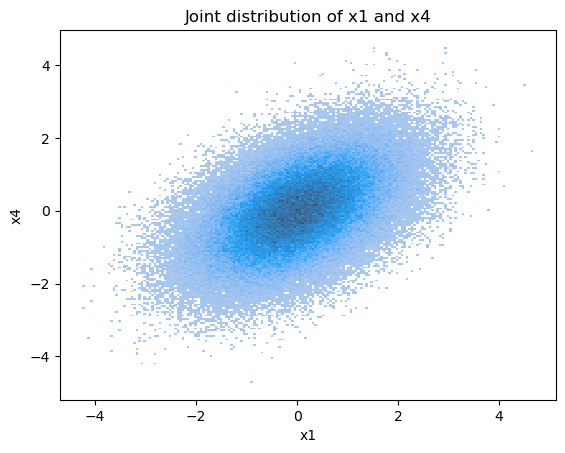

In [1]:
### Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

### Let's create a model with three interacting real terms, and one dummy term with no impact on the outcome, but with correlation to the first real term,
### In the model: x_1x_2 + x_3 = y
### With x_1 = eps_1, x_2 = eps_2, x_3 = eps_3, x_4 = 1/2*eps_1 + eps_4*sqrt(3/4)
### In other words, all x:s are uniform normal, all x:s are uncorrelated, except for eps 1 and eps 4 which have covariance 1/2.
### Where eps_n is N(0,1)

N = 150000
generator = np.random.default_rng(seed=42)
eps = np.asmatrix(generator.normal(loc=0,scale=1,size=(N,4))) # To get the matrix [eps1, eps2, eps3, eps4], where each epsn is a column vector
xs  = (np.asmatrix([[1,   0, 0, 0],                         #
                    [0,   1, 0, 0],                         # This returns the matrix x, composed of column vectors xn. 
                    [0,   0, 1, 0],                         # First it multiplies the transpose of the above eps matrix by a generating matrix to get the matrix [x_1^T, x_2^T, x_3^T, x_4^T]
                    [1/2, 0, 0, np.sqrt(3/4)]]) * eps.T).T  # Then it transposes to get the matrix [x_1, x_2, x_3, x_4]
y   = np.multiply(xs[:,0],xs[:,1]) + xs[:,2] # Generate ys by formula, note that the acsess xs[:,0] flattens xs[:,0] to a row (numpy is a bit silly) so the transpose for x1x2 is the opposite of what it should be!
data = pd.DataFrame(data=np.concatenate([xs, y],1), columns=['x1','x2','x3','x4','y'])

''' Check that our generated covarying matrixes have the right variance structure'''
variance = plt.figure();
plt.title("Comparison of distribution of x1 and x4, labeled (0) and (1)");
sns.histplot(xs[:,(0,3)]); # Plots the histogrm of x_1 and x_4. Uses the ndarray acsess to get every row (by ellipses), in columns 0 and 3 (by tuple).

covariance = plt.figure();
plt.title("Joint distribution of x1 and x4");
sns.histplot(data=data, x='x1', y='x4');

### Now that we've seen that $X$ is correctly distributed let's take a look at how $Y$ is distributed.
We can decompose the unconditional distribution of the result Y into a sum of a simple normal distribution and a chisquared distribution.

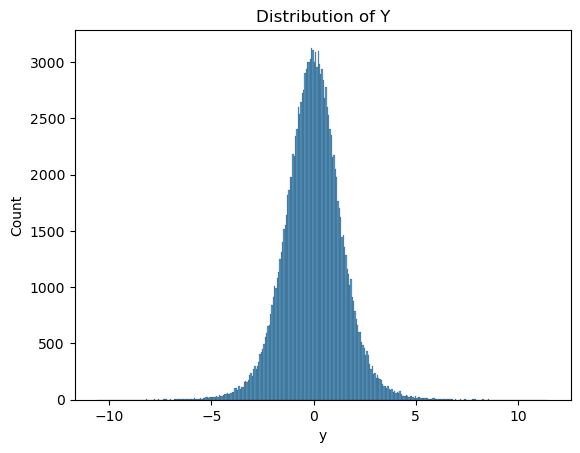

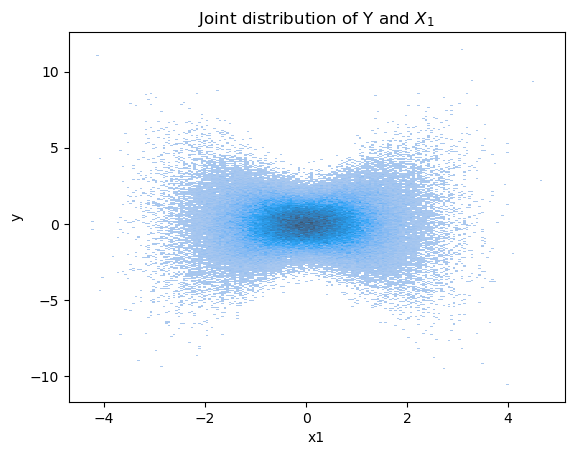

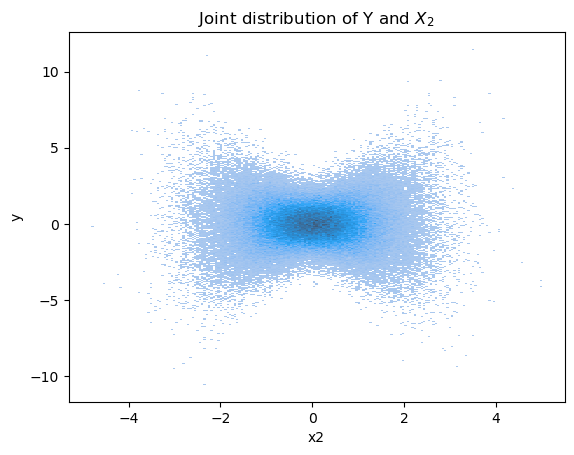

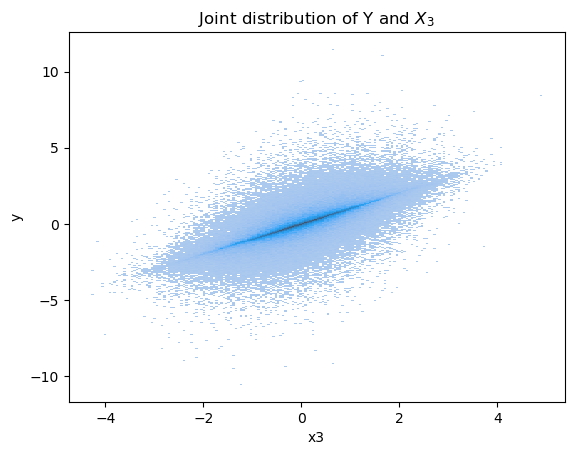

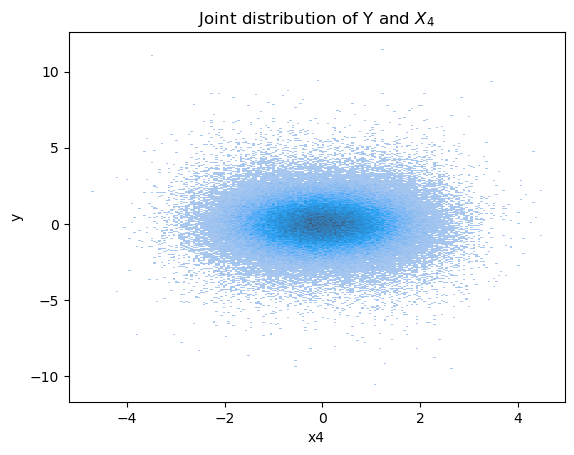

In [2]:
''' Plot distribution of Y '''
variance = plt.figure();
plt.title("Distribution of Y");
sns.histplot(data=data['y']); # type:ignore (Slight abuse of the function)

covariancex1y = plt.figure();
plt.title("Joint distribution of Y and $X_1$");
sns.histplot(data=data, x='x1', y='y');

covariancex2y = plt.figure();
plt.title("Joint distribution of Y and $X_2$");
sns.histplot(data=data, x='x2', y='y');

covariancex3y = plt.figure();
plt.title("Joint distribution of Y and $X_3$");
sns.histplot(data=data, x='x3', y='y');

covariancex4y = plt.figure();
plt.title("Joint distribution of Y and $X_4$");
sns.histplot(data=data, x='x4', y='y');

### And let's see a 3d representation of the result.

In [3]:
import plotly.express as px
from mpl_toolkits.mplot3d import Axes3D

fig = px.scatter_3d(
    data,
    x='x1',
    y='x2',
    z='x3',
    color='y',
    opacity=0.7,
    size_max=5
)
fig.update_traces(marker=dict(size=1.5))
fig.show()

### Now finally we can start applying a tree model!
What we have constructed is a case where easy gains in expectation can be made be predicting up and down along slices of $X_3$, but signifigant prediction hides behind figuring out the matrix of high values where $X_1$ and $X_2$ share sign, and low values when they differ.

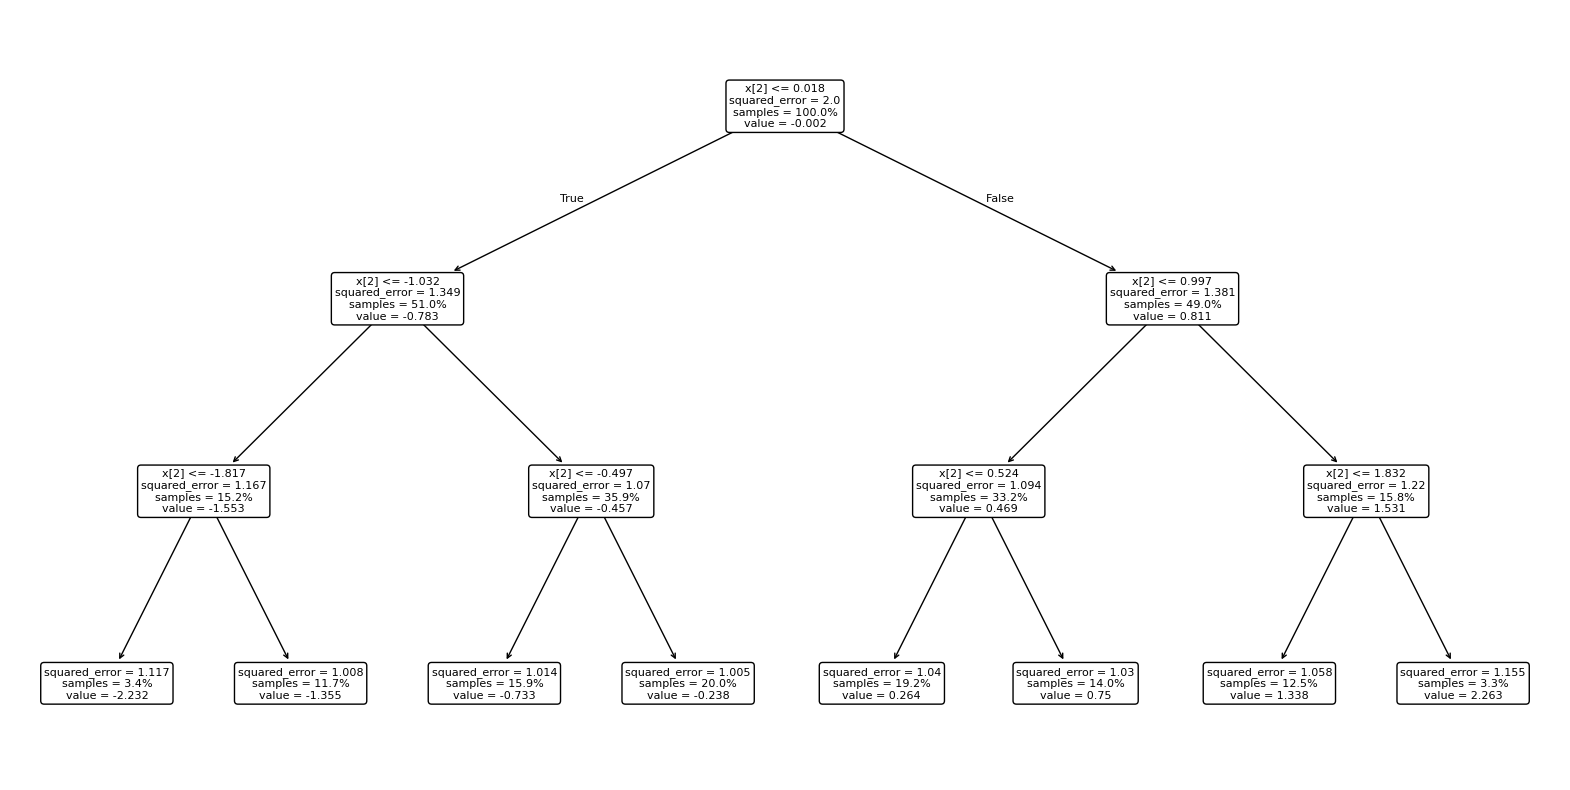

In [4]:
import sklearn.tree as Stree
from sklearn.inspection import DecisionBoundaryDisplay

shallowTree = Stree.DecisionTreeRegressor(criterion='squared_error',splitter='best', max_depth=3).fit(data.get(['x1','x2','x3','x4']), y=data['y'],); #type:ignore
plt.figure(figsize=(20,10))
Stree.plot_tree(shallowTree,fontsize=8,rounded=True, proportion=True);


A single shallow tree finds all its nodes dedicated to slicing along $X_3$. Let's see if a deeper tree can do better!

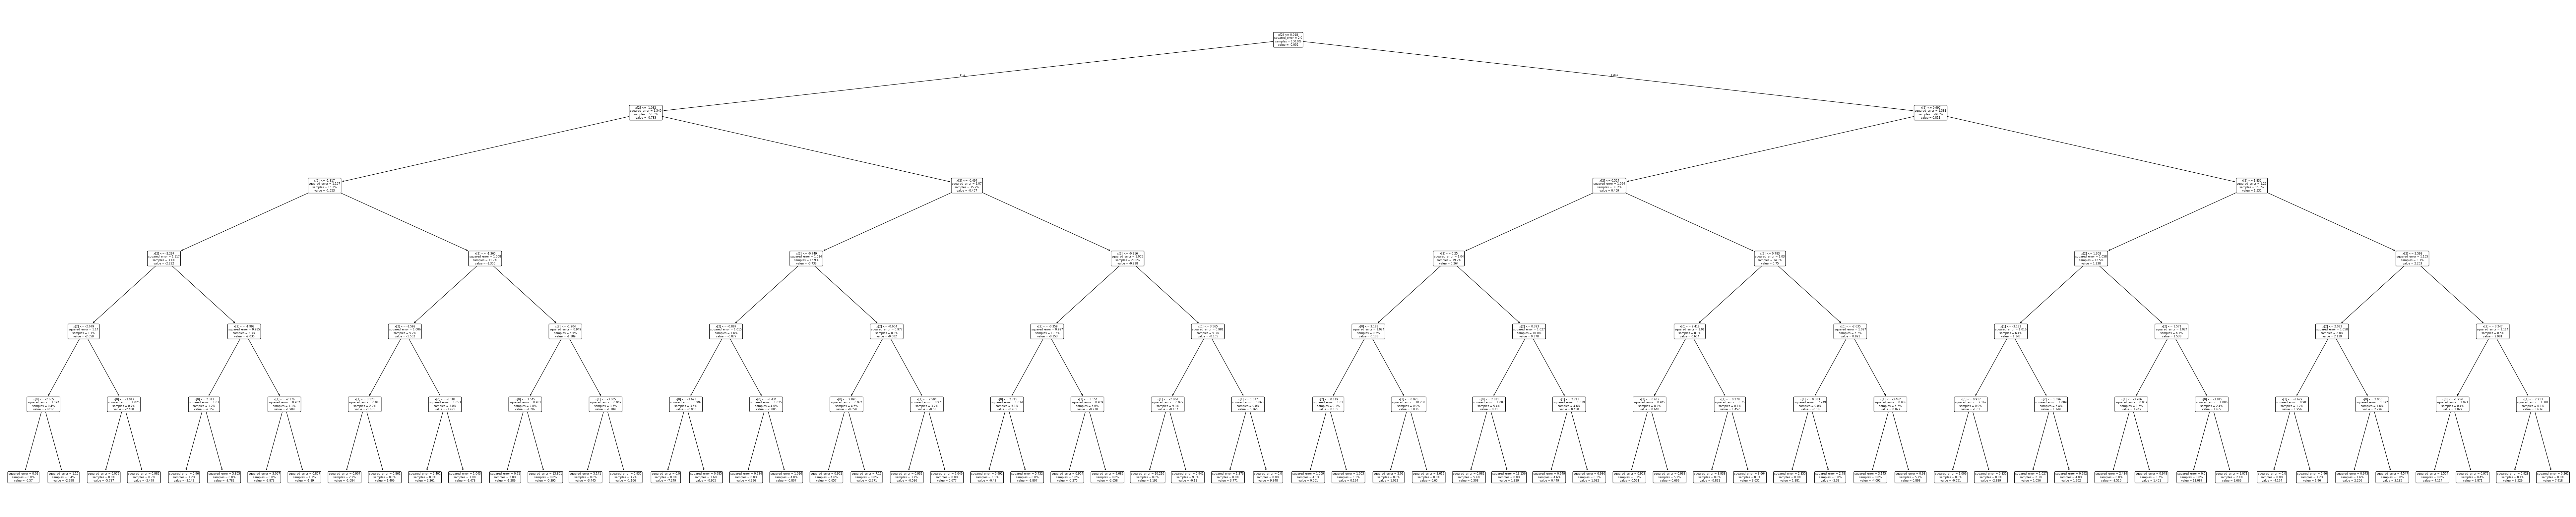

In [5]:
deepTree = Stree.DecisionTreeRegressor(criterion='squared_error',splitter='best', max_depth=6).fit(data.get(['x1','x2','x3','x4']), y=data['y'],); #type:ignore
plt.figure(figsize=(100,20))
Stree.plot_tree(deepTree,fontsize=6,rounded=True, proportion=True);

It still fails to identify the cross behaivour! This is because of a fundamental weakness of simple trees, since making a split along $X_1$ or $X_2$ will give little information on it's own, at best gaining accuracy in one end of the complementing variable at the cost of the other, this type of interaction will be very difficult to discover, and we run out of layers and samples to find these connections relatively fast. Let's make one extra deep tree to see this!

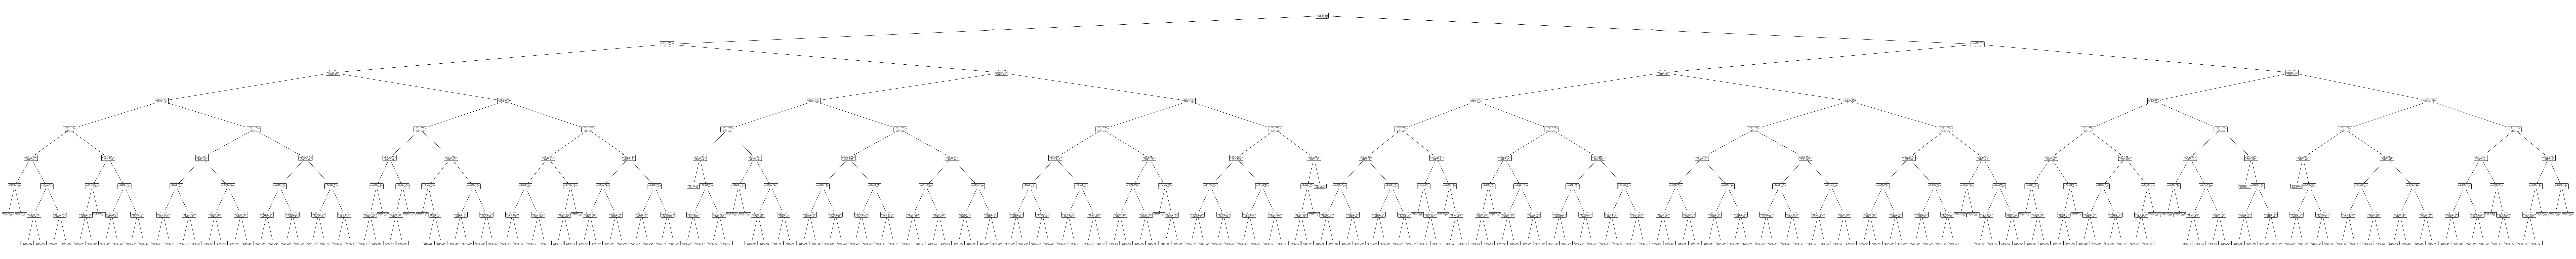

In [6]:
xtradeepTree = Stree.DecisionTreeRegressor(criterion='squared_error',splitter='best', max_depth=8).fit(data.get(['x1','x2','x3','x4']), y=data['y'],); #type:ignore
plt.figure(figsize=(200,20))
Stree.plot_tree(xtradeepTree,fontsize=5,rounded=True, proportion=True);

Finally after this number of splits, most paths carry an interaction term, but many of these paths are now down to 0 samples, since we've split the data into (up to) 256 buckets. The information carried in a non interacting $X_1$ or $X_2$ split is zero! Since the two are symettric (the bowtie shape)! This means that the first split required for an interaction term to emerge can only come by accident, or if by coincidence, once the data is filtered down enough to carry noise.

This example really is needlessly cruel, since $X_1$ and $X_2$ enter only in an uncorrelated interaction, if the two expressed themselves in any other way that could act as a nuclues to create splits in one, who's conditioning can then be capitilized on by splitting in the other. Another way we could save the trees is by expanding the regressors by creating interaction terms, which would also fix the problem.

This was mostly an exercise in getting basic familiarity with the sklearn tree functions but it was also fun to play with synthetic data and see a case where trees fail.